# Using ChoiceRank to understand network traffic

This notebook provides a quick example on how to use ChoiceRank to estimate transitions along the edges of a network based only on the marginal traffic at the nodes.

In [1]:
import networkx as nx
import numpy as np

import choix

%matplotlib inline

## 1. Generating sample data

First, we will generate sample data.
This includes

1. generating a network,
2. generating a parameter for each node of the network,
3. generating samples of choices in the network.

In [2]:
n_items = 8
p_edge = 0.3
n_samples = 3000

# 1. Generate a network.
graph = nx.erdos_renyi_graph(n_items, p_edge, directed=True)

# 2. Generate a parameter for each node.
params = choix.generate_params(n_items, interval=2.0)

# 3. Generate samples of choices in the network.
transitions = np.zeros((n_items, n_items))
for _ in range(n_samples):
    src = np.random.choice(n_items)
    neighbors = list(graph.successors(src))
    if len(neighbors) == 0:
        continue
    dst = choix.compare(neighbors, params)
    transitions[src, dst] += 1

The network looks as follows

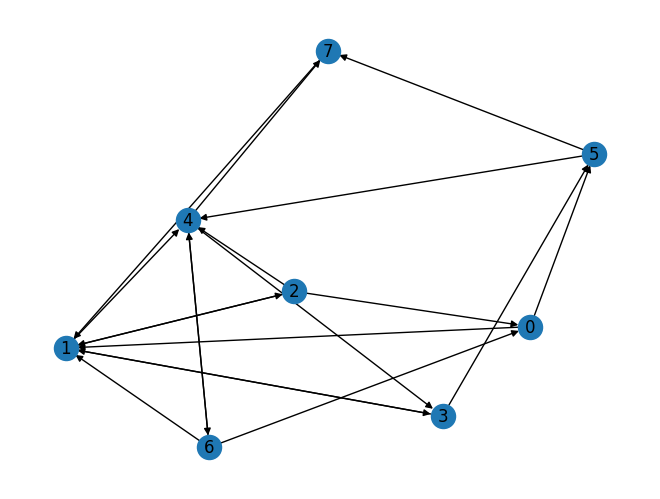

In [3]:
nx.draw(graph, with_labels=True)

Now we aggregate the all the transitions into *incoming traffic* and *outgoing traffic*.

In [4]:
traffic_in = transitions.sum(axis=0)
traffic_out = transitions.sum(axis=1)

print("incoming traffic:", traffic_in)
print("outgoing traffic:", traffic_out)

incoming traffic: [  85.  748.  160.   85. 1005.  537.  192.  188.]
outgoing traffic: [355. 389. 388. 385. 344. 396. 391. 352.]


## 2. Estimating transitions using ChoiceRank

ChoiceRank can be used to recover the transitions on the network based only on:

1. information about the structure of the network, and
2. the (marginal) incoming and outgoing traffic at each node.

ChoiceRank works under the assumption that each node has a latent "preference" score, and that transitions follow Luce's choice model.

In [5]:
params = choix.choicerank(graph, traffic_in, traffic_out)

We can attempt to reconstruct the transition matrix using the marginal traffic data and the parameters.

In [6]:
est = np.zeros((n_items, n_items))
for src in range(n_items):
    neighbors = list(graph.successors(src))
    if len(neighbors) == 0:
        continue
    probs = choix.probabilities(neighbors, params)
    est[src, neighbors] = traffic_out[src] * probs

In [7]:
with np.printoptions(precision=0):
    print("True transition matrix:")
    print(transitions)

    print("\nEstimated transition matrix:")
    print(est)

    print("\nDifference:")
    print(transitions - est)

True transition matrix:
[[  0.  94.   0.   0.   0. 261.   0.   0.]
 [  0.   0. 160.  37. 192.   0.   0.   0.]
 [ 46. 102.   0.   0. 240.   0.   0.   0.]
 [  0. 109.   0.   0.   0. 276.   0.   0.]
 [  0.   0.   0.  48.   0.   0. 192. 104.]
 [  0.   0.   0.   0. 312.   0.   0.  84.]
 [ 39.  91.   0.   0. 261.   0.   0.   0.]
 [  0. 352.   0.   0.   0.   0.   0.   0.]]

Estimated transition matrix:
[[  0.  98.   0.   0.   0. 257.   0.   0.]
 [  0.   0. 160.  32. 198.   0.   0.   0.]
 [ 43.  96.   0.   0. 249.   0.   0.   0.]
 [  0. 106.   0.   0.   0. 279.   0.   0.]
 [  0.   0.   0.  54.   0.   0. 192.  98.]
 [  0.   0.   0.   0. 306.   0.   0.  90.]
 [ 43.  97.   0.   0. 251.   0.   0.   0.]
 [  0. 352.   0.   0.   0.   0.   0.   0.]]

Difference:
[[ 0. -4.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  5. -6.  0.  0.  0.]
 [ 3.  6.  0.  0. -9.  0.  0.  0.]
 [ 0.  3.  0.  0.  0. -3.  0.  0.]
 [ 0.  0.  0. -6.  0.  0.  0.  6.]
 [ 0.  0.  0.  0.  6.  0.  0. -6.]
 [-4. -6.  0.  0. 10.  0.  0.  0.